In [1]:
from ultralytics import YOLO
from dataset import YOLO11dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import shutil
import tqdm

In [2]:
def copy_files(file_names, src_dir, dst_dir):
    for fname in file_names:
        # Copy image
        shutil.copy2(
            os.path.join(src_dir, "images", fname),
            os.path.join(dst_dir, "images", fname)
        )
        # Copy corresponding label
        label_name = os.path.splitext(fname)[0] + '.txt'
        shutil.copy2(
            os.path.join(src_dir, "labels", label_name),
            os.path.join(dst_dir, "labels", label_name)
        )

In [3]:
# train test split
root_dir = r'/home/eu/Marangi/projects/Road-Damage-Detection/Jap_only/Jap_only_lincracks'
data_dir = os.path.join(root_dir, "data")
train_dir = os.path.join(root_dir, "train")
val_dir = os.path.join(root_dir, "val")
for dir_path in [train_dir, val_dir]:
    os.makedirs(dir_path + "/images", exist_ok=True)
    os.makedirs(dir_path + "/labels", exist_ok=True)

image_files = [f for f in os.listdir(os.path.join(data_dir, "images")) if f.endswith('.jpg')]
train_files, val_files = train_test_split(image_files, test_size=0.1, random_state=42)
copy_files(train_files, data_dir, train_dir)
copy_files(val_files, data_dir, val_dir)

In [7]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (images, targets) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        targets = targets.to(device)
        
        # Forward pass
        loss = model(images, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = images.to(device)
            targets = targets.to(device)
            
            #forward pass + loss computation
            loss = model(images, targets)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [5]:
# Training setup
train_dataset = YOLO11dataset(
    img_dir=r'C:/Users/marangi/Desktop/projects/RDD2022/data/United_States/train/images', 
    label_dir=r'C:/Users/marangi/Desktop/projects/RDD2022/data/United_States/train/labels',
    img_size=640
)

val_dataset = YOLO11dataset(
    img_dir=r'C:/Users/marangi/Desktop/projects/RDD2022/data/United_States/val/images', 
    label_dir=r'C:/Users/marangi/Desktop/projects/RDD2022/data/United_States/val/labels',
    img_size=640
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
device = 'cpu' #(ToDo: GPU)
model = YOLO("yolov8n.pt")
num_epochs = 100
hyperparams = {
    'lr0': 0.001,  # initial learning rate for Adam
    'weight_decay': 0.0005,
    'box': 7.5,    # box loss gain
    'cls': 0.5,    # cls loss gain
    'dfl': 1.5,    # dfl loss gain
}
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=hyperparams['lr0'], 
                           weight_decay=hyperparams['weight_decay'])

100%|██████████| 6.25M/6.25M [00:00<00:00, 10.4MB/s]


In [ ]:
#Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    
    # Validate
    val_loss = validate(model, val_loader, device)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Save checkpoint
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, f'checkpoint_epoch_{epoch+1}.pt')

# Save final model
torch.save(model.state_dict(), 'final_model.pt')

In [7]:
from ultralytics import YOLO
from dataset import YOLO11dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import shutil
import tqdm

In [8]:
#torch.cuda.get_device_name(0)
torch.cuda.is_available()

True

In [10]:
model = YOLO("yolov8n.pt")
results = model.train(
    data = r"/home/eu/Marangi/projects/Road-Damage-Detection/A1.4_RDD_dataset/dataset.yaml",
    epochs = 300,
    imgsz = 640,
    batch = 16,
    patience = 10,
    device = 0,
    amp = False
)

Ultralytics 8.3.27 🚀 Python-3.11.10 torch-2.5.1+rocm6.2 CUDA:0 (AMD Radeon VII, 16368MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/eu/Marangi/projects/Road-Damage-Detection/A1.4_RDD_dataset/dataset.yaml, epochs=300, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav

train: Scanning /home/eu/Marangi/projects/Road-Damage-Detection/A1.4_RDD_dataset/China_Drone/labels... 35556 images, 12861 backgrounds, 0 corrupt: 100%|██████████| 35556/35556 [00:13<00:00, 2715.29it/s]


train: New cache created: /home/eu/Marangi/projects/Road-Damage-Detection/A1.4_RDD_dataset/China_Drone/labels.cache


val: Scanning /home/eu/Marangi/projects/Road-Damage-Detection/A1.4_RDD_dataset/Czech/labels... 2829 images, 1757 backgrounds, 0 corrupt: 100%|██████████| 2829/2829 [00:01<00:00, 2061.75it/s]

val: New cache created: /home/eu/Marangi/projects/Road-Damage-Detection/A1.4_RDD_dataset/Czech/labels.cache


Plotting labels to /home/eu/Marangi/projects/Road-Damage-Detection/runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/eu/Marangi/projects/Road-Damage-Detection/runs/detect/train2
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/2223 [00:00<?, ?it/s]MIOpen(HIP): Warning [hip_mem_get_info_wrapper] hipMemGetInfo error, status: 1
MIOpen(HIP): Warning [hip_mem_get_info_wrapper] hipMemGetInfo error, status: 1
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback AI] Solver <GemmBwdRest>, workspace required: 921600, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback AI] Solver <GemmBwdRest>, workspace required: 3686400, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback AI] Solver <GemmBwdRest>, workspace required: 3686400, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback AI] Solver <GemmBwdRest>, workspace required: 7372800, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback AI] Solver <GemmBwdRest>, workspace required: 14745600, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback AI] Solver <GemmBwdRest>, wor

KeyboardInterrupt: 

In [2]:
import os

In [5]:
def save_sorted_folder_structure(root_dir, output_file='folder_structure.txt'):
    with open(output_file, 'w') as f:
        for dirpath, dirnames, _ in os.walk(root_dir):
            # Ordina le directory in ordine alfabetico
            dirnames.sort()
            level = dirpath.replace(root_dir, '').count(os.sep)
            indent = ' ' * 4 * level
            f.write(f"{indent}{os.path.basename(dirpath)}/\n")

# Sostituisci 'root_dir' con il percorso alla directory principale del tuo dataset
save_sorted_folder_structure('/home/eu/Marangi/projects/Road-Damage-Detection/A1.4_RDD_dataset')

In [10]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import yaml

def analyze_split(labels_path, split_name=""):
    class_counts = defaultdict(int)
    total_images = 0
    images_with_annotations = 0
    
    label_files = glob.glob(os.path.join(labels_path, '*.txt'))
    
    for txt_file in label_files:
        total_images += 1
        with open(txt_file, 'r') as f:
            lines = f.readlines()
            if lines:
                images_with_annotations += 1
                for line in lines:
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
    
    # Calculate percentages
    total_annotations = sum(class_counts.values())
    class_percentages = {k: (v/total_annotations)*100 for k, v in class_counts.items()}
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'{split_name} Set Analysis', fontsize=16)
    
    # Class distribution
    plt.subplot(1, 2, 1)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    ax = sns.barplot(x=classes, y=counts)
    plt.title('Class Distribution')
    plt.xlabel('Class Type (0: Longitudinal, 1: Transverse)')
    plt.ylabel('Count')
    
    # Add percentage labels on bars
    for i, p in enumerate(ax.patches):
        percentage = class_percentages[i]
        ax.annotate(f'{percentage:.1f}%', 
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='bottom')
    
    # Images with/without annotations
    plt.subplot(1, 2, 2)
    plt.pie([images_with_annotations, total_images - images_with_annotations], 
            labels=['With Annotations', 'Background'],
            autopct='%1.1f%%')
    plt.title('Images Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{split_name} Dataset Statistics:")
    print(f"Total images: {total_images}")
    print(f"Images with annotations: {images_with_annotations}")
    print(f"Background images: {total_images - images_with_annotations}")
    print("\nClass distribution:")
    class_names = {0: "Longitudinal_Crack", 1: "Transverse_Crack"}
    for class_id, count in sorted(class_counts.items()):
        percentage = class_percentages[class_id]
        print(f"Class {class_id} ({class_names[class_id]}): {count} instances ({percentage:.1f}%)")
    
    return class_counts, total_images, images_with_annotations

def analyze_dataset(yaml_path):
    with open(yaml_path, 'r') as f:
        dataset_config = yaml.safe_load(f)
    
    base_path = dataset_config['path']
    train_labels_path = os.path.join(base_path, 'train', 'labels')
    val_labels_path = os.path.join(base_path, 'val', 'labels')
    
    # Analyze both splits
    train_stats = analyze_split(train_labels_path, "Training")
    val_stats = analyze_split(val_labels_path, "Validation")

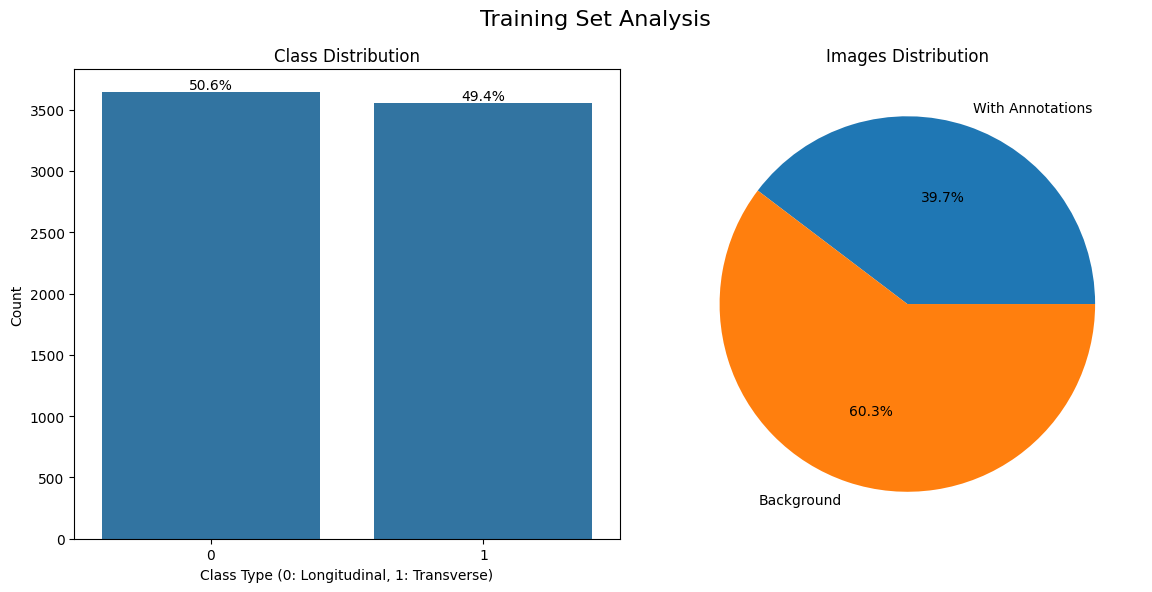


Training Dataset Statistics:
Total images: 9455
Images with annotations: 3751
Background images: 5704

Class distribution:
Class 0 (Longitudinal_Crack): 3647 instances (50.6%)
Class 1 (Transverse_Crack): 3558 instances (49.4%)


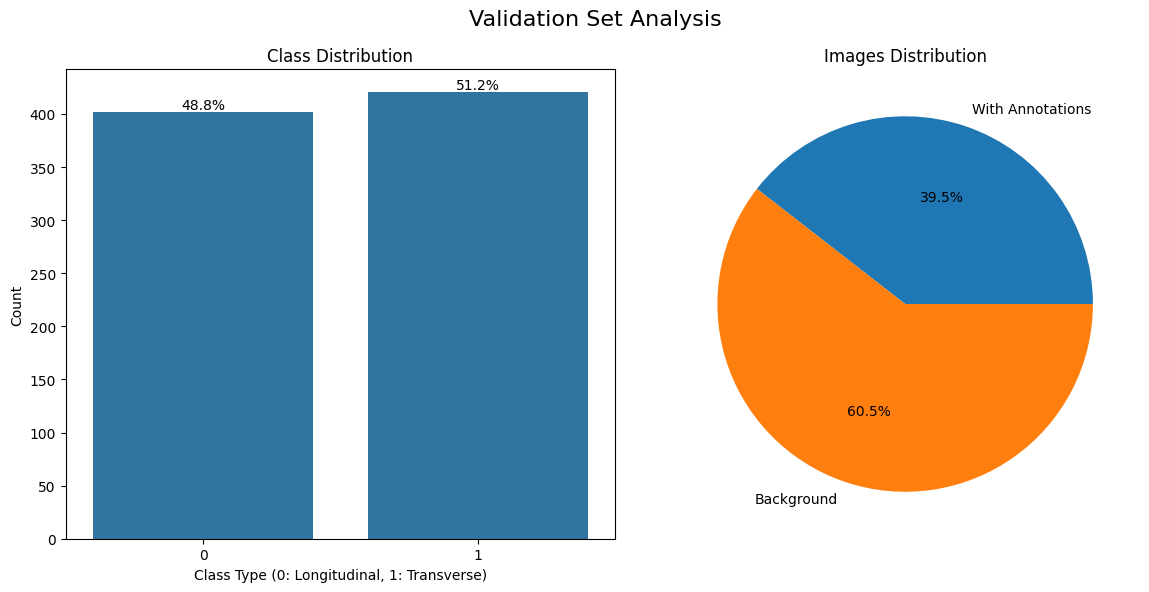


Validation Dataset Statistics:
Total images: 1051
Images with annotations: 415
Background images: 636

Class distribution:
Class 0 (Longitudinal_Crack): 402 instances (48.8%)
Class 1 (Transverse_Crack): 421 instances (51.2%)


In [11]:
yaml_path = "/home/eu/Marangi/projects/Road-Damage-Detection/Jap_only/Jap_only_lincracks/jap_only.yaml"
analyze_dataset(yaml_path)